In [1]:
import math
import numpy as np
import networkx as nx
import pandas as pd

# Frank-Wolfe Algorithm (User Equilibrium)

This section construct the Frank-Wolfe Algorithm to solve User Equilibrium problem.

Note: 
1. The All-or-nothing will be done using Bellman-Ford algorithm in Networkx packages. 
2. The alpha would be solved directly using bisection (I also checked with the Goal Seek in Excel)
3. Convergence is checked manually in Excel - Terminate at 12th Iteration for tolerance 0.0005

### I. Network Properties

number of arcs = 76
number of nodes = 24
number of considered pairs = 196


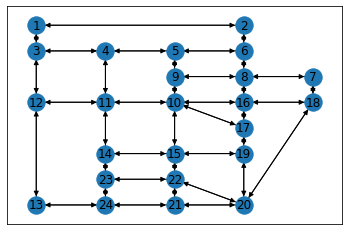

In [7]:
#Define a graph

G=nx.read_weighted_edgelist("UTM598_dpurba2.txt", create_using=nx.DiGraph())
G1=nx.read_weighted_edgelist("UTM598_dpurba2_cap.txt", create_using=nx.DiGraph())
G2=nx.read_weighted_edgelist("UTM598_dpurba2_path.txt", create_using=nx.DiGraph())
G.add_node('1', loc=(1,8))
G.add_node('2', loc=(4,8))
G.add_node('3', loc=(1,7))
G.add_node('4', loc=(2,7))
G.add_node('5', loc=(3,7))
G.add_node('6', loc=(4,7))
G.add_node('7', loc=(5,6))
G.add_node('8', loc=(4,6))
G.add_node('9', loc=(3,6))
G.add_node('10', loc=(3,5))
G.add_node('11', loc=(2,5))
G.add_node('12', loc=(1,5))
G.add_node('13', loc=(1,1))
G.add_node('14', loc=(2,3))
G.add_node('15', loc=(3,3))
G.add_node('16', loc=(4,5))
G.add_node('17', loc=(4,4))
G.add_node('18', loc=(5,5))
G.add_node('19', loc=(4,3))
G.add_node('20', loc=(4,1))
G.add_node('21', loc=(3,1))
G.add_node('22', loc=(3,2))
G.add_node('23', loc=(2,2))
G.add_node('24', loc=(2,1))

pos = nx.get_node_attributes(G, 'loc')
time = nx.get_edge_attributes(G,'weight')
capacity = nx.get_edge_attributes(G1,'weight')
allnothing = nx.get_edge_attributes(G2,'weight')
edgelist=list(G.edges())
nodelist=list(G.nodes())

nfrom = []
nto = []
for i in range(len(edgelist)):
    nfrom.append(edgelist[i][0])
    nto.append(edgelist[i][1])

# Origin and Destination

noncentral = ['3','6','7','8', '9', '12','16','17','18','23']
origins = ["1", "2", "4", "5", "10", "11", "13", "14", "15", "19", "20", "21", "22", "24"]
destinations = ["1", "2", "4", "5", "10", "11", "13", "14", "15", "19", "20", "21", "22", "24"]
OD = [[a,b] for a in origins
        for b in destinations]

demand = {'1':{'1':0, '2':1320, '4':1320, '5':1320, '10':1080, '11':1100, '13':1250, '14':990, '15':950, '19':900, '20':590, '21':590, '22':770, '24':740},
    '2':{'1':1320, '2':0, '4':1250, '5':1300, '10':1100, '11':1120, '13':900, '14':950, '15':940, '19':1300, '20':590, '21':680, '22':670, '24':590},
    '4':{'1':1320, '2':1250, '4':0, '5':1320, '10':1080, '11':1070, '13':950, '14':900, '15':840, '19':800, '20':1620, '21':640, '22':590, '24':800},
    '5':{'1':1320, '2':1300, '4':1320, '5':0, '10':1130, '11':970, '13':910, '14':880, '15':810, '19':730, '20':800, '21':810, '22':940, '24':590},
    '10':{'1':1080, '2':1100, '4':1080, '5':1130, '10':0, '11':1330, '13':900, '14':990, '15':1320, '19':1170, '20':950, '21':900, '22':970, '24':590},
    '11':{'1':1100, '2':1120, '4':1070, '5':970, '10':1330, '11':0, '13':940, '14':1320, '15':1110, '19':950, '20':740, '21':610, '22':1100, '24':1050},
    '13':{'1':1250, '2':900, '4':950, '5':910, '10':900, '11':940, '13':0, '14':870, '15':860, '19':680, '20':590, '21':620, '22':670, '24':1320},
    '14':{'1':990, '2':950, '4':900, '5':880, '10':990, '11':1320, '13':870, '14':0, '15':1320, '19':1130, '20':950, '21':870, '22':900, '24':1130},
    '15':{'1':950, '2':940, '4':840, '5':810, '10':1320, '11':1110, '13':860, '14':1320, '15':0, '19':1320, '20':1270, '21':1140, '22':1320, '24':910},
    '19':{'1':900, '2':1300, '4':800, '5':730, '10':1170, '11':950, '13':680, '14':1130, '15':1320, '19':0, '20':1320, '21':1110, '22':1100, '24':800},
    '20':{'1':590, '2':590, '4':1620, '5':800, '10':950, '11':740, '13':590, '14':980, '15':1270, '19':1320, '20':0, '21':1320, '22':1320, '24':610},
    '21':{'1':590, '2':680, '4':640, '5':810, '10':900, '11':610, '13':620, '14':870, '15':1140, '19':1110, '20':1320, '21':0, '22':1320, '24':1320},
    '22':{'1':770, '2':670, '4':590, '5':940, '10':970, '11':1100, '13':670, '14':900, '15':1320, '19':1100, '20':1320, '21':1320, '22':0, '24':1130},
    '24':{'1':740, '2':590, '4':800, '5':590, '10':590, '11':1050, '13':1320, '14':1130, '15':910, '19':800, '20':610, '21':1320, '22':1130, '24':0}}


nx.draw_networkx(G, pos, arrows=True, with_labels=True)
print('number of arcs = '+ str(len(edgelist)))
print('number of nodes = '+ str(len(nodelist)))
print('number of considered pairs = ' + str(len(OD)))

### II. All-or-Nothing Algorithm

In [3]:
# All-or-Nothing Algorithm
def allnothing_funct(timefeed,G2,OD,nfrom,nto,noncentral,origins,destinations):
    # Define new graph (G_iter) with new feed time
    merged_edgelist = [(nfrom[i], nto[i], timefeed[i]) for i in range(0, len(edgelist))] 

    G_iter = nx.DiGraph()
    G_iter.add_weighted_edges_from(merged_edgelist)
    timeiter = nx.get_edge_attributes(G_iter,'weight')
    #nx.draw_networkx(G_iter, pos, arrows=True, with_labels=True)
    #nx.draw_networkx_edge_labels(G_iter, pos, edge_labels=timeiter)
    #print(timeiter)

    # Bellman-Ford Algorithm
    allpath = dict(nx.all_pairs_bellman_ford_path(G_iter, weight='weight'))

    # Clean all pairs path to only consider OD pairs for Project 1
    for i in range(len(noncentral)):
        del allpath[noncentral[i]] 

    for i in range(len(origins)):
        for j in range(len(noncentral)):
            del allpath[origins[i]][noncentral[j]]

    # Finding Ya
    ya_iter = []
    allnothing = nx.get_edge_attributes(G2,'weight')
    ya_iter = allnothing

    for k in range(len(OD)):
        ODpath = allpath[OD[k][0]][OD[k][1]]
        usedlink = []

        if len(ODpath) > 1:
            for j in range(len(ODpath)-1):
                B = []
                B.append(ODpath[j])
                B.append(ODpath[j+1])
                usedlink.append(B)

        for i in range(len(usedlink)):
            (usedlink[i][0],usedlink[i][1])
            ya_iter[(usedlink[i][0],usedlink[i][1])]+=demand[OD[k][0]][OD[k][1]]

    allnothing = nx.get_edge_attributes(G2,'weight')
    return ya_iter

### III. Bisection Algorithm

In [4]:
# Bisection Algorithm

def bisection_funct(x,y,edgelist,time,capacity):
    ya_iter= []
    xa_iter = []
    ya_iter = y
    xa_iter = x

    a = 0
    b = 1

    def fa(alpha):
        fa = 0
        for i in range(len(edgelist)):
            fa+=time[edgelist[i]]*((xa_iter[edgelist[i]] + alpha * (ya_iter[edgelist[i]]-xa_iter[edgelist[i]]))
                                   +0.03/(capacity[edgelist[i]]**4)
                                   *((xa_iter[edgelist[i]]+alpha*(ya_iter[edgelist[i]]-xa_iter[edgelist[i]]))**5))
        return fa

    def dfa(alpha):
        dfa = 0
        for i in range(len(edgelist)):
            dfa+=time[edgelist[i]]*((ya_iter[edgelist[i]]-xa_iter[edgelist[i]])
                       +0.03/(capacity[edgelist[i]]**4)*5
                       *(ya_iter[edgelist[i]]-xa_iter[edgelist[i]])
                       *(xa_iter[edgelist[i]] + alpha * (ya_iter[edgelist[i]]-xa_iter[edgelist[i]]))**4)
        return dfa


    m = (a+b)/2

    while (np.abs(a-b)) >=0.0000000001:
        if np.sign(dfa(m))< 0:
            a=m
        else:
            b=m

        m = (a+b)/2
        
    return m

### IV. Initiation

In [5]:
# Initiation
time0 = time
time0_list=list(time0.values())

xa = allnothing_funct(time0_list,G2,OD,nfrom,nto,noncentral,origins,destinations)

Z = 0
for i in range(len(edgelist)):
    Z+=time[edgelist[i]]*((xa[edgelist[i]])+0.03/capacity[edgelist[i]]**4*((xa[edgelist[i]]))**5)           

print('Initiation:')
print('Objective Z = ' + str(Z))
print('Xa_0 = ')
print(xa)


Initiation:
Objective Z = 1221143.0891292018
Xa_0 = 
{('1', '2'): 4300.0, ('1', '3'): 11600.0, ('2', '1'): 4300.0, ('2', '6'): 11390.0, ('3', '1'): 11600.0, ('3', '4'): 10650.0, ('3', '12'): 8730.0, ('6', '2'): 11390.0, ('6', '5'): 8570.0, ('6', '8'): 10720.0, ('4', '3'): 10650.0, ('4', '5'): 13890.0, ('4', '11'): 10360.0, ('12', '3'): 8730.0, ('12', '11'): 1840.0, ('12', '13'): 10570.0, ('5', '4'): 13890.0, ('5', '6'): 8570.0, ('5', '9'): 5850.0, ('11', '4'): 10360.0, ('11', '10'): 3810.0, ('11', '12'): 1840.0, ('11', '14'): 14560.0, ('9', '5'): 5850.0, ('9', '8'): 2040.0, ('9', '10'): 7890.0, ('8', '6'): 10720.0, ('8', '7'): 4950.0, ('8', '9'): 2040.0, ('8', '16'): 3730.0, ('7', '8'): 4950.0, ('7', '18'): 4950.0, ('18', '7'): 4950.0, ('18', '16'): 1690.0, ('18', '20'): 5900.0, ('16', '8'): 3730.0, ('16', '10'): 1690.0, ('16', '17'): 3730.0, ('16', '18'): 950.0, ('10', '9'): 7890.0, ('10', '11'): 4550.0, ('10', '15'): 6690.0, ('10', '16'): 950.0, ('10', '17'): 1170.0, ('15', '10'): 66

### V. Main Iterations

In [6]:
error = 10
xa_old = xa

for kk in range(12):
    # Revise Time
    time_list= []
    timefeed = []

    for i in range(len(list(time.values()))):
        time_list.append(list(time.values())[i]*(1+0.15*(list(xa.values())[i]/list(capacity.values())[i])**4))

    timefeed = time_list

    # All-or-Nothing 
    ya = allnothing_funct(timefeed,G2,OD,nfrom,nto,noncentral,origins,destinations)

    # Find Alpha
    alpha = bisection_funct(xa,ya,edgelist,time,capacity)

    # New Direction
    xa_newiterlist = []
    for j in range(len(edgelist)):
        xa_newiterlist.append(xa[edgelist[j]] + alpha * (ya[edgelist[j]]-xa[edgelist[j]]))

    xa_newiter = allnothing
    for ii in range(len(edgelist)):
        xa_newiter[edgelist[ii]] =  xa_newiterlist[ii]

    # Ojective
    xa = xa_newiter
    xa1 = xa
    Z = 0
    for jj in range(len(edgelist)):
        Z+=time[edgelist[jj]]*((xa[edgelist[jj]])+0.03/capacity[edgelist[jj]]**4*((xa[edgelist[jj]]))**5)           

    # Error
    errorlist = []
    for i in range(len(edgelist)):
        errorlist.append((xa_newiter[edgelist[i]]-xa_old[edgelist[i]])**2)

    error = (sum(errorlist))**0.5/sum(list(xa_old.values()))


    xa1 = xa
    print('\nIteration:' + str(kk))
    print ('alpha = ' + str(alpha))
    print('Objective Z = ' + str(Z))
    print('Ya = ')
    print(ya)
    print('Xa = ')
    print(xa)
    
    time_list= []
    xa_newiterlist = []
    


Iteration:0
alpha = 0.30163424406782724
Objective Z = 1217175.1262948762
Ya = 
{('1', '2'): 4300.0, ('1', '3'): 11600.0, ('2', '1'): 4300.0, ('2', '6'): 11390.0, ('3', '1'): 11600.0, ('3', '4'): 8560.0, ('3', '12'): 10820.0, ('6', '2'): 11390.0, ('6', '5'): 6500.0, ('6', '8'): 12790.0, ('4', '3'): 8560.0, ('4', '5'): 16270.0, ('4', '11'): 3820.0, ('12', '3'): 10820.0, ('12', '11'): 3930.0, ('12', '13'): 10570.0, ('5', '4'): 14200.0, ('5', '6'): 8570.0, ('5', '9'): 8230.0, ('11', '4'): 5890.0, ('11', '10'): 6740.0, ('11', '12'): 3930.0, ('11', '14'): 5140.0, ('9', '5'): 8230.0, ('9', '8'): 2040.0, ('9', '10'): 12340.0, ('8', '6'): 10720.0, ('8', '7'): 4950.0, ('8', '9'): 4110.0, ('8', '16'): 3730.0, ('7', '8'): 4950.0, ('7', '18'): 4950.0, ('18', '7'): 4950.0, ('18', '16'): 1690.0, ('18', '20'): 6640.0, ('16', '8'): 3730.0, ('16', '10'): 1690.0, ('16', '17'): 3730.0, ('16', '18'): 1690.0, ('10', '9'): 10270.0, ('10', '11'): 6150.0, ('10', '15'): 14420.0, ('10', '16'): 1690.0, ('10', '1


Iteration:9
alpha = 0.2788207595294807
Objective Z = 1212163.784661081
Ya = 
{('1', '2'): 4300.0, ('1', '3'): 11600.0, ('2', '1'): 4300.0, ('2', '6'): 11390.0, ('3', '1'): 11600.0, ('3', '4'): 7610.0, ('3', '12'): 11770.0, ('6', '2'): 11390.0, ('6', '5'): 8570.0, ('6', '8'): 10720.0, ('4', '3'): 7610.0, ('4', '5'): 14730.0, ('4', '11'): 6480.0, ('12', '3'): 11770.0, ('12', '11'): 4880.0, ('12', '13'): 10570.0, ('5', '4'): 14730.0, ('5', '6'): 8570.0, ('5', '9'): 6690.0, ('11', '4'): 6480.0, ('11', '10'): 4910.0, ('11', '12'): 4880.0, ('11', '14'): 11440.0, ('9', '5'): 6690.0, ('9', '8'): 2040.0, ('9', '10'): 8730.0, ('8', '6'): 10720.0, ('8', '7'): 4950.0, ('8', '9'): 2040.0, ('8', '16'): 3730.0, ('7', '8'): 4950.0, ('7', '18'): 4950.0, ('18', '7'): 4950.0, ('18', '16'): 1690.0, ('18', '20'): 6640.0, ('16', '8'): 3730.0, ('16', '10'): 1690.0, ('16', '17'): 3730.0, ('16', '18'): 1690.0, ('10', '9'): 8730.0, ('10', '11'): 4910.0, ('10', '15'): 8120.0, ('10', '16'): 1690.0, ('10', '17'):